In [ ]:
# Define whether to use a small subset of data for testing
# is_test = True

In [2]:
# Set the dataset path
dataset = "data"

In [3]:
# Import utility functions for data loading and path joining
from utils.data_loader import DataLoader
from utils.data_io import join_path

In [4]:
# Initialize the data loader with the dataset path
data_loader = DataLoader(dataset)

In [5]:
# Load training and test data
train_df = data_loader.get_data_train()
test_df = data_loader.get_data_test()

In [6]:
# Get data description (column names for labels and text)
data_desc = data_loader.get_data_desc()
label_column = data_desc['label_column']
text_column = data_desc['text_column']

In [7]:
# Extract and print keyword concepts
keyword_concepts = data_loader.get_keyword_concepts()
keywords = []
for k in keyword_concepts.keys():
    keywords += keyword_concepts[k]
print(keywords)

['hypertension', 'coronary', 'infarction', 'myocardial', 'ischemia', 'hepatitis', 'biliary', 'intestinal', 'pancrea', 'bowel', 'respiratory', 'pulmonary', 'hemorrhage', 'pathogen', 'gene', 'carcinoma', 'cancer', 'tumor', 'squamous', 'benign', 'brain', 'dementia', 'headache', 'nerve', 'atrophy']


In [8]:
# Extract abstract concepts
abstract_concepts = data_loader.get_abstract_concepts()
abstract_concepts = [ac['abstract_concept_name'] for ac in abstract_concepts]
print(abstract_concepts)

['Cardiac Conditions', 'Vascular Issues', 'Heart Muscle Diseases', 'Liver and Gallbladder Ailments', 'Intestinal Tract Disorders', 'Pancreatic Conditions', 'Respiratory Tract Issues', 'Bleeding Disorders', 'Infectious Agents and Genetic Factors', 'Malignant Tumors', 'Neoplastic Growths', 'Non-Malignant Growths', 'Central Nervous System Disorders', 'Neurological Symptoms', 'Degenerative Brain Conditions']


In [9]:
# Import LabelEncoder for encoding labels
from sklearn.preprocessing import LabelEncoder

In [10]:
# Encode labels in training and test data
le = LabelEncoder()
le.fit(train_df[label_column])
train_df[label_column] = le.transform(train_df[label_column])
test_df[label_column] = le.transform(test_df[label_column])

In [11]:
# Get the list of label names
labels = list(le.classes_)
print(labels)

['cardiovascular diseases', 'digestive system diseases', 'general pathological conditions', 'neoplasms', 'nervous system diseases']


In [12]:
# If in test mode, sample one example per label
if is_test:
    train_df = train_df.groupby(label_column).sample(5)
    test_df = test_df.groupby(label_column).sample(5)

In [13]:
# Convert data to lists for training
train_texts = train_df[text_column].to_list()
train_labels = train_df[label_column].to_list()
test_texts = test_df[text_column].to_list()
test_labels = test_df[label_column].to_list()

In [14]:
# Split training data into training and validation sets
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

In [15]:
# Define paths for pre-trained NLI models
keyword_nli_model_path = join_path(dataset, 'scorer_model', 'keyword_scorer')
abstract_nli_model_path = join_path(dataset, 'scorer_model', 'abstract_scorer')

In [16]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader as TorchDataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import networkx as nx
from matplotlib import cm

In [17]:
def load_model(path):
    """Load a pre-trained BERT model and tokenizer from the specified path."""
    model = BertForSequenceClassification.from_pretrained(path)
    tokenizer = BertTokenizer.from_pretrained(path)
    return model, tokenizer

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [19]:
import warnings
from transformers import logging

# Tắt tất cả cảnh báo từ transformers
logging.set_verbosity_error()

# Hoặc tắt mọi cảnh báo Python (nếu muốn toàn cục)
warnings.filterwarnings("ignore")

In [20]:
def precompute_nli_scores(texts, concepts, tokenizer, model, device=device, batch_size=512):
    """
    Precompute NLI scores for a list of texts against a list of concepts.
    
    Args:
        texts (list): List of input texts to score.
        concepts (list): List of concept names (keywords or abstract concepts).
        tokenizer: BERT tokenizer for encoding text-concept pairs.
        model: Pre-trained BERT model for NLI scoring.
        device (str): Device to run computation ('cuda' or 'cpu').
        batch_size (int): Number of texts to process per batch.
    
    Returns:
        torch.Tensor: Tensor of shape [n_texts, n_concepts] with NLI entailment scores.
    """
    # Move model to device and set to evaluation mode
    model = model.to(device)
    model.eval()
    
    # Initialize list to store scores for all texts
    all_scores = []
    
    # Process texts in batches to reduce memory usage
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_scores = []
        
        # Compute NLI scores for each concept
        for concept in concepts:
            # Tokenize batch of text-concept pairs
            inputs = tokenizer(batch_texts, [concept] * len(batch_texts),
                              return_tensors='pt', padding=True, truncation=True, max_length=512)
            inputs = {key: val.to(device) for key, val in inputs.items()}
            
            # Run model without gradient computation
            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.softmax(outputs.logits, dim=-1)
                # Extract entailment scores (index 1 in NLI output)
                batch_scores.append(probs[:, 1].cpu())
        
        # Stack scores for all concepts in this batch: [batch_size, n_concepts]
        all_scores.append(torch.stack(batch_scores, dim=1))
    
    # Concatenate all batch scores into a single tensor: [n_texts, n_concepts]
    return torch.cat(all_scores, dim=0)

# Load models and tokenizers
device = 'cuda' if torch.cuda.is_available() else 'cpu'
keyword_scorer, keyword_tokenizer = load_model(keyword_nli_model_path)
abstract_scorer, abstract_tokenizer = load_model(abstract_nli_model_path)

# Precompute scores for train, validation, and test sets
train_keyword_scores = precompute_nli_scores(train_texts, keywords, keyword_tokenizer, keyword_scorer, device)
train_abstract_scores = precompute_nli_scores(train_texts, abstract_concepts, abstract_tokenizer, abstract_scorer, device)
val_keyword_scores = precompute_nli_scores(val_texts, keywords, keyword_tokenizer, keyword_scorer, device)
val_abstract_scores = precompute_nli_scores(val_texts, abstract_concepts, abstract_tokenizer, abstract_scorer, device)
test_keyword_scores = precompute_nli_scores(test_texts, keywords, keyword_tokenizer, keyword_scorer, device)
test_abstract_scores = precompute_nli_scores(test_texts, abstract_concepts, abstract_tokenizer, abstract_scorer, device)

In [21]:
class ConceptNetwork(nn.Module):
    """
    A neural network that models relationships between keywords, abstract concepts, and labels.
    Uses precomputed NLI scores and learnable embeddings to make predictions.
    """
    def __init__(self, concept_names, embedding_dim=128):
        """
        Args:
            concept_names (list): List of [keywords, abstract_concepts, labels].
            embedding_dim (int): Dimension of concept embeddings.
        """
        super(ConceptNetwork, self).__init__()
        self.embedding_dim = embedding_dim
        self.keywords, self.abstract_concepts, self.labels = concept_names
        
        # Learnable embeddings for keywords, abstract concepts, and labels
        self.keyword_embeddings = nn.Parameter(torch.randn(len(self.keywords), embedding_dim))
        self.abstract_embeddings = nn.Parameter(torch.randn(len(self.abstract_concepts), embedding_dim))
        self.label_embeddings = nn.Parameter(torch.randn(len(self.labels), embedding_dim))
        
        # Learnable reliability weights (betas) for combining direct and relational scores
        self.keyword_betas = nn.Parameter(torch.zeros(len(self.keywords)))
        self.abstract_betas = nn.Parameter(torch.zeros(len(self.abstract_concepts)))
        
        # Linear layer to predict semantic embeddings (for SBERT alignment)
        self.semantic_predictor = nn.Linear(embedding_dim, 384)  # SBERT output dimension
    
    def forward(self, keyword_scores, abstract_scores):
        """
        Forward pass of the network.
        
        Args:
            keyword_scores (torch.Tensor): Precomputed NLI scores for keywords [batch_size, n_keywords].
            abstract_scores (torch.Tensor): Precomputed NLI scores for abstract concepts [batch_size, n_abstracts].
        
        Returns:
            tuple: (predictions, keyword_semantic, abstract_semantic, label_semantic, keyword_scores, abstract_scores)
                - predictions: Predicted label probabilities [batch_size, n_labels].
                - keyword_semantic: Semantic embeddings for keywords [n_keywords, 384].
                - abstract_semantic: Semantic embeddings for abstract concepts [n_abstracts, 384].
                - label_semantic: Semantic embeddings for labels [n_labels, 384].
                - keyword_scores: Input keyword scores (passed through).
                - abstract_scores: Computed abstract scores.
        """
        # Step 1: Keyword layer (use precomputed NLI scores directly)
        # Shape: [batch_size, n_keywords]
        
        # Step 2: Abstract layer (combine direct NLI scores with keyword-based relational scores)
        # Compute attention between keyword and abstract embeddings
        attn_kw_abs = torch.matmul(self.keyword_embeddings, self.abstract_embeddings.T)  # [n_keywords, n_abstracts]
        attn_kw_abs = torch.softmax(attn_kw_abs, dim=0)  # Normalize over keywords
        relation_kw_abs = torch.matmul(keyword_scores, attn_kw_abs)  # [batch_size, n_abstracts]
        
        # Combine direct and relational scores using learnable betas
        abstract_betas = torch.sigmoid(self.abstract_betas)  # [n_abstracts]
        abstract_scores = abstract_scores * abstract_betas + relation_kw_abs * (1 - abstract_betas)
        
        # Step 3: Label layer (compute predictions using abstract-to-label attention)
        attn_abs_lbl = torch.matmul(self.abstract_embeddings, self.label_embeddings.T)  # [n_abstracts, n_labels]
        attn_abs_lbl = torch.softmax(attn_abs_lbl, dim=0)  # Normalize over abstract concepts
        predictions = torch.matmul(abstract_scores, attn_abs_lbl)  # [batch_size, n_labels]
        
        # Step 4: Semantic predictions (for SBERT alignment)
        keyword_semantic = self.semantic_predictor(self.keyword_embeddings)  # [n_keywords, 384]
        abstract_semantic = self.semantic_predictor(self.abstract_embeddings)  # [n_abstracts, 384]
        label_semantic = self.semantic_predictor(self.label_embeddings)  # [n_labels, 384]
        
        return predictions, keyword_semantic, abstract_semantic, label_semantic, keyword_scores, abstract_scores

In [ ]:
def train_model(model, train_keyword_scores, train_abstract_scores, train_labels,
                val_keyword_scores, val_abstract_scores, val_labels,
                concept_names, sbert_embeddings, batch_size=32, num_epochs=50,
                patience=5, lambda_semantic=0.1, device=device):
    """
    Train the ConceptNetwork model with precomputed NLI scores and SBERT embeddings.
    
    Args:
        model (nn.Module): The ConceptNetwork model.
        train_keyword_scores (torch.Tensor): Precomputed keyword NLI scores for training texts.
        train_abstract_scores (torch.Tensor): Precomputed abstract NLI scores for training texts.
        train_labels (list): Training labels.
        val_keyword_scores (torch.Tensor): Precomputed keyword NLI scores for validation texts.
        val_abstract_scores (torch.Tensor): Precomputed abstract NLI scores for validation texts.
        val_labels (list): Validation labels.
        concept_names (list): List of [keywords, abstract_concepts, labels].
        sbert_embeddings (list): SBERT embeddings for keywords, abstract concepts, and labels.
        batch_size (int): Batch size for training.
        num_epochs (int): Number of training epochs.
        patience (int): Number of epochs to wait for early stopping.
        lambda_semantic (float): Weight for semantic loss.
        device (str): Device to run training ('cuda' or 'cpu').
    
    Returns:
        tuple: (train_losses, val_losses) - Lists of training and validation losses per epoch.
    """
    # Move model to device
    model = model.to(device)
    
    # Initialize optimizer, loss functions, and mixed precision scaler
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    classification_loss = nn.CrossEntropyLoss()
    semantic_loss_fn = nn.MSELoss()
    scaler = GradScaler()
    
    # Convert SBERT embeddings to tensors
    sbert_tensors = [torch.tensor(arr, device=device, dtype=torch.float32) for arr in sbert_embeddings]
    
    # Create DataLoaders for training and validation
    train_dataset = TensorDataset(train_keyword_scores, train_abstract_scores, torch.tensor(train_labels, dtype=torch.long))
    train_loader = TorchDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    
    val_dataset = TensorDataset(val_keyword_scores, val_abstract_scores, torch.tensor(val_labels, dtype=torch.long))
    val_loader = TorchDataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
    
    # Track losses and early stopping
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        epoch_train_loss = 0
        for batch_keyword_scores, batch_abstract_scores, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            # Move batch to device
            batch_keyword_scores = batch_keyword_scores.to(device)
            batch_abstract_scores = batch_abstract_scores.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass with mixed precision
            optimizer.zero_grad()
            with autocast():
                predictions, keyword_semantic, abstract_semantic, label_semantic, _, _ = model(
                    batch_keyword_scores, batch_abstract_scores
                )
                # Compute classification loss
                pred_loss = classification_loss(predictions, batch_labels)
                # Compute semantic loss (align embeddings with SBERT)
                semantic_loss = sum(semantic_loss_fn(emb, sbert_tensors[i]) for i, emb in enumerate(
                    [keyword_semantic, abstract_semantic, label_semantic]
                ))
                # Combine losses
                total_loss = pred_loss + lambda_semantic * semantic_loss
            
            # Backward pass with mixed precision
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_train_loss += total_loss.item()
        
        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_keyword_scores, batch_abstract_scores, batch_labels in val_loader:
                # Move batch to device
                batch_keyword_scores = batch_keyword_scores.to(device)
                batch_abstract_scores = batch_abstract_scores.to(device)
                batch_labels = batch_labels.to(device)
                
                with autocast():
                    predictions, keyword_semantic, abstract_semantic, label_semantic, _, _ = model(
                        batch_keyword_scores, batch_abstract_scores
                    )
                    # Compute classification loss
                    pred_loss = classification_loss(predictions, batch_labels)
                    # Compute semantic loss (align embeddings with SBERT)
                    semantic_loss = sum(semantic_loss_fn(emb, sbert_tensors[i]) for i, emb in enumerate(
                        [keyword_semantic, abstract_semantic, label_semantic]
                    ))
                    # Combine losses
                    total_loss = pred_loss + lambda_semantic * semantic_loss
                    val_loss += total_loss.item()
        
        # Average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print("Saved new best model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load('best_model.pt'))
    print("Loaded best model from 'best_model.pt'.")
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')
    plt.show()
    plt.close()
    
    return train_losses, val_losses

In [23]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch 1, Train Loss: 1.7185, Val Loss: 1.6934
Saved new best model.


Epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 2, Train Loss: 1.7108, Val Loss: 1.6868
Saved new best model.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Epoch 3, Train Loss: 1.7035, Val Loss: 1.6806
Saved new best model.


Epoch 4: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch 4, Train Loss: 1.6963, Val Loss: 1.6749
Saved new best model.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Epoch 5, Train Loss: 1.6895, Val Loss: 1.6696
Saved new best model.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch 6, Train Loss: 1.6829, Val Loss: 1.6648
Saved new best model.


Epoch 7: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Epoch 7, Train Loss: 1.6766, Val Loss: 1.6605
Saved new best model.


Epoch 8: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch 8, Train Loss: 1.6706, Val Loss: 1.6565
Saved new best model.


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Epoch 9, Train Loss: 1.6650, Val Loss: 1.6529
Saved new best model.


Epoch 10: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch 10, Train Loss: 1.6597, Val Loss: 1.6496
Saved new best model.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Epoch 11, Train Loss: 1.6548, Val Loss: 1.6465
Saved new best model.


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 12, Train Loss: 1.6503, Val Loss: 1.6437
Saved new best model.


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Epoch 13, Train Loss: 1.6460, Val Loss: 1.6411
Saved new best model.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Epoch 14, Train Loss: 1.6421, Val Loss: 1.6386
Saved new best model.


Epoch 15: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch 15, Train Loss: 1.6383, Val Loss: 1.6362
Saved new best model.


Epoch 16: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 16, Train Loss: 1.6347, Val Loss: 1.6340
Saved new best model.


Epoch 17: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 17, Train Loss: 1.6311, Val Loss: 1.6318
Saved new best model.


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch 18, Train Loss: 1.6275, Val Loss: 1.6298
Saved new best model.


Epoch 19: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 19, Train Loss: 1.6238, Val Loss: 1.6278
Saved new best model.


Epoch 20: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 20, Train Loss: 1.6199, Val Loss: 1.6258
Saved new best model.


Epoch 21: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch 21, Train Loss: 1.6158, Val Loss: 1.6239
Saved new best model.


Epoch 22: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 22, Train Loss: 1.6114, Val Loss: 1.6221
Saved new best model.


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Epoch 23, Train Loss: 1.6071, Val Loss: 1.6203
Saved new best model.


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 24, Train Loss: 1.6028, Val Loss: 1.6186
Saved new best model.


Epoch 25: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Epoch 25, Train Loss: 1.5987, Val Loss: 1.6170
Saved new best model.


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch 26, Train Loss: 1.5951, Val Loss: 1.6154
Saved new best model.


Epoch 27: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch 27, Train Loss: 1.5919, Val Loss: 1.6138
Saved new best model.


Epoch 28: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch 28, Train Loss: 1.5891, Val Loss: 1.6122
Saved new best model.


Epoch 29: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Epoch 29, Train Loss: 1.5867, Val Loss: 1.6105
Saved new best model.


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 30, Train Loss: 1.5844, Val Loss: 1.6087
Saved new best model.


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 31, Train Loss: 1.5823, Val Loss: 1.6069
Saved new best model.


Epoch 32: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Epoch 32, Train Loss: 1.5803, Val Loss: 1.6051
Saved new best model.


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Epoch 33, Train Loss: 1.5784, Val Loss: 1.6035
Saved new best model.


Epoch 34: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Epoch 34, Train Loss: 1.5767, Val Loss: 1.6021
Saved new best model.


Epoch 35: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 35, Train Loss: 1.5752, Val Loss: 1.6009
Saved new best model.


Epoch 36: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Epoch 36, Train Loss: 1.5739, Val Loss: 1.5999
Saved new best model.


Epoch 37: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Epoch 37, Train Loss: 1.5729, Val Loss: 1.5991
Saved new best model.


Epoch 38: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Epoch 38, Train Loss: 1.5720, Val Loss: 1.5984
Saved new best model.


Epoch 39: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Epoch 39, Train Loss: 1.5712, Val Loss: 1.5979
Saved new best model.


Epoch 40: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Epoch 40, Train Loss: 1.5706, Val Loss: 1.5974
Saved new best model.


Epoch 41: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch 41, Train Loss: 1.5701, Val Loss: 1.5970
Saved new best model.


Epoch 42: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Epoch 42, Train Loss: 1.5696, Val Loss: 1.5967
Saved new best model.


Epoch 43: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Epoch 43, Train Loss: 1.5691, Val Loss: 1.5964
Saved new best model.


Epoch 44: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch 44, Train Loss: 1.5687, Val Loss: 1.5961
Saved new best model.


Epoch 45: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Epoch 45, Train Loss: 1.5683, Val Loss: 1.5959
Saved new best model.


Epoch 46: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Epoch 46, Train Loss: 1.5680, Val Loss: 1.5957
Saved new best model.


Epoch 47: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch 47, Train Loss: 1.5677, Val Loss: 1.5955
Saved new best model.


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 48, Train Loss: 1.5674, Val Loss: 1.5953
Saved new best model.


Epoch 49: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Epoch 49, Train Loss: 1.5671, Val Loss: 1.5951
Saved new best model.


Epoch 50: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 50, Train Loss: 1.5669, Val Loss: 1.5949
Saved new best model.


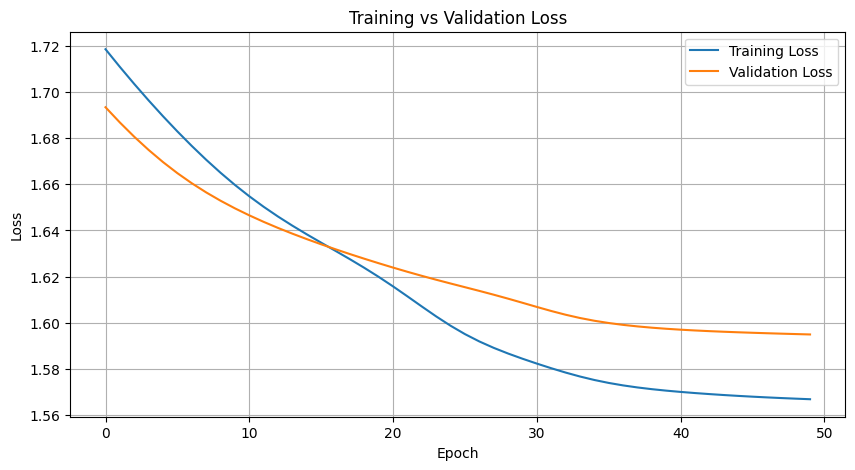

In [24]:
# Initialize SentenceTransformer for SBERT embeddings
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute SBERT embeddings for concepts
keyword_sbert = sbert_model.encode(keywords)
abstract_sbert = sbert_model.encode(abstract_concepts)
label_sbert = sbert_model.encode(labels)
sbert_embeddings = [keyword_sbert, abstract_sbert, label_sbert]

# Initialize and train the model
concept_names = [keywords, abstract_concepts, labels]
model = ConceptNetwork(concept_names)
train_losses, val_losses = train_model(
    model, train_keyword_scores, train_abstract_scores, train_labels,
    val_keyword_scores, val_abstract_scores, val_labels,
    concept_names, sbert_embeddings
)

In [25]:
def test_model(model, test_keyword_scores, test_abstract_scores, test_labels, concept_names, batch_size=32, device=device):
    """
    Test the ConceptNetwork model on the test set.
    
    Args:
        model (nn.Module): The trained ConceptNetwork model.
        test_keyword_scores (torch.Tensor): Precomputed keyword NLI scores for test texts.
        test_abstract_scores (torch.Tensor): Precomputed abstract NLI scores for test texts.
        test_labels (list): Test labels.
        concept_names (list): List of [keywords, abstract_concepts, labels].
        batch_size (int): Batch size for testing.
        device (str): Device to run testing ('cuda' or 'cpu').
    """
    model = model.to(device)
    model.eval()
    predictions = []
    true_labels = []
    
    test_dataset = TensorDataset(test_keyword_scores, test_abstract_scores, torch.tensor(test_labels, dtype=torch.long))
    test_loader = TorchDataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
    
    with torch.no_grad():
        for batch_keyword_scores, batch_abstract_scores, batch_labels in tqdm(test_loader, desc="Testing"):
            batch_keyword_scores = batch_keyword_scores.to(device)
            batch_abstract_scores = batch_abstract_scores.to(device)
            
            outputs, _, _, _, _, _ = model(batch_keyword_scores, batch_abstract_scores)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(batch_labels.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=concept_names[2]))

In [30]:
# Test the model
test_model(model, test_keyword_scores, test_abstract_scores, test_labels, concept_names)

Testing: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Classification Report:
                                 precision    recall  f1-score   support

        cardiovascular diseases       0.23      0.60      0.33         5
      digestive system diseases       0.00      0.00      0.00         5
general pathological conditions       0.00      0.00      0.00         5
                      neoplasms       0.45      1.00      0.62         5
        nervous system diseases       0.00      0.00      0.00         5

                       accuracy                           0.32        25
                      macro avg       0.14      0.32      0.19        25
                   weighted avg       0.14      0.32      0.19        25



In [27]:
def interpretable_prediction(model, test_text, test_label, test_keyword_scores, test_abstract_scores, concept_names, device='cuda'):
    """
    Generate interpretable predictions for a single test sample.
    
    Args:
        model (nn.Module): The trained ConceptNetwork model.
        test_text (str): The input text for prediction.
        test_label (int): The true label index.
        test_keyword_scores (torch.Tensor): Precomputed keyword NLI scores for the test text.
        test_abstract_scores (torch.Tensor): Precomputed abstract NLI scores for the test text.
        concept_names (list): List of [keywords, abstract_concepts, labels].
        device (str): Device to run prediction ('cuda' or 'cpu').
    
    Returns:
        tuple: (keyword_scores, abstract_scores, label_probs, predicted_label_idx)
    """
    model = model.to(device)
    model.eval()
    
    print("\nInterpretable Prediction for Sample:")
    print(f"Input Text: {test_text}")
    print(f"True Label: {concept_names[2][test_label]}")
    
    # Ensure scores are 2D tensors (batch_size=1)
    keyword_scores = test_keyword_scores[:1].to(device)
    abstract_scores = test_abstract_scores[:1].to(device)
    
    with torch.no_grad():
        predictions, _, _, _, keyword_scores, abstract_scores = model(keyword_scores, abstract_scores)
        label_probs = torch.softmax(predictions, dim=1)[0].cpu().numpy()
        predicted_label_idx = torch.argmax(predictions, dim=1).cpu().numpy()[0]
        
        print(f"Predicted Label: {concept_names[2][predicted_label_idx]}")
        print("Label Probabilities:")
        for label, prob in zip(concept_names[2], label_probs):
            print(f"  {label}: {prob:.4f}")
        
        print("Top Keyword Scores:")
        for idx in torch.topk(keyword_scores[0], k=5).indices:
            print(f"  {concept_names[0][idx]}: {keyword_scores[0, idx]:.4f}")
        
        print("Top Abstract Concept Scores:")
        for idx in torch.topk(abstract_scores[0], k=5).indices:
            print(f"  {concept_names[1][idx]}: {abstract_scores[0, idx]:.4f}")
    
    return keyword_scores.cpu(), abstract_scores.cpu(), label_probs, predicted_label_idx

def visualize_network(model, concept_names, keyword_scores, abstract_scores, label_probs, predicted_label_idx):
    """Visualize the concept network as a graph."""
    G = nx.DiGraph()
    
    # Add nodes for keywords, abstract concepts, and labels
    for i, kw in enumerate(concept_names[0]):
        G.add_node(f"kw_{i}", label=kw, layer='keyword', score=keyword_scores[0, i].item())
    for i, ac in enumerate(concept_names[1]):
        G.add_node(f"ac_{i}", label=ac, layer='abstract', score=abstract_scores[0, i].item())
    for i, lbl in enumerate(concept_names[2]):
        G.add_node(f"lbl_{i}", label=lbl, layer='label', prob=label_probs[i])
    
    # Add edges based on attention weights
    attn_kw_abs = torch.softmax(torch.matmul(model.keyword_embeddings, model.abstract_embeddings.T), dim=0).cpu().detach().numpy()
    attn_abs_lbl = torch.softmax(torch.matmul(model.abstract_embeddings, model.label_embeddings.T), dim=0).cpu().detach().numpy()
    
    for i in range(len(concept_names[0])):
        for j in range(len(concept_names[1])):
            if attn_kw_abs[i, j] > 0.1:  # Threshold for visualization
                G.add_edge(f"kw_{i}", f"ac_{j}", weight=attn_kw_abs[i, j])
    
    for i in range(len(concept_names[1])):
        for j in range(len(concept_names[2])):
            if attn_abs_lbl[i, j] > 0.1:  # Threshold for visualization
                G.add_edge(f"ac_{i}", f"lbl_{j}", weight=attn_abs_lbl[i, j])
    
    # Visualize the graph
    plt.figure(figsize=(12, 8))
    pos = nx.multipartite_layout(G, subset_key='layer')
    node_colors = [G.nodes[n]['score'] if G.nodes[n]['layer'] != 'label' else G.nodes[n]['prob'] for n in G.nodes]
    nx.draw(G, pos, with_labels=True, labels={n: G.nodes[n]['label'] for n in G.nodes},
            node_color=node_colors, cmap=plt.cm.viridis, node_size=500, font_size=8)
    edge_colors = [G[u][v]['weight'] for u, v in G.edges]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.Blues)
    plt.title("Concept Network Visualization")
    plt.show()


Interpretable Prediction for Sample:
Input Text: Toxic carbamazepine concentrations following cardiothoracic surgery and myocardial infarction. Carbamazepine is being used more frequently in the U.S. as an initial agent of choice to treat generalized tonic-clonic, mixed, and partial seizures with complex symptomatology. Carbamazepine is extensively metabolized in the liver; however, there is little information available on its pharmacokinetics in patients following surgery or myocardial infarction, or in those with liver disease. We report a case of a patient who attained toxic carbamazepine serum concentrations (ranging from 18.2 to 21.5 micrograms/mL) two days after cardiothoracic surgery and an intraoperative myocardial infarction, and experienced lethargy, diplopia, dysarthria, diaphoresis, and horizontal and downgaze nystagmus. These alterations in serum carbamazepine concentration normalized ten days after surgery. They may have been due to a combination of changes in protein bi

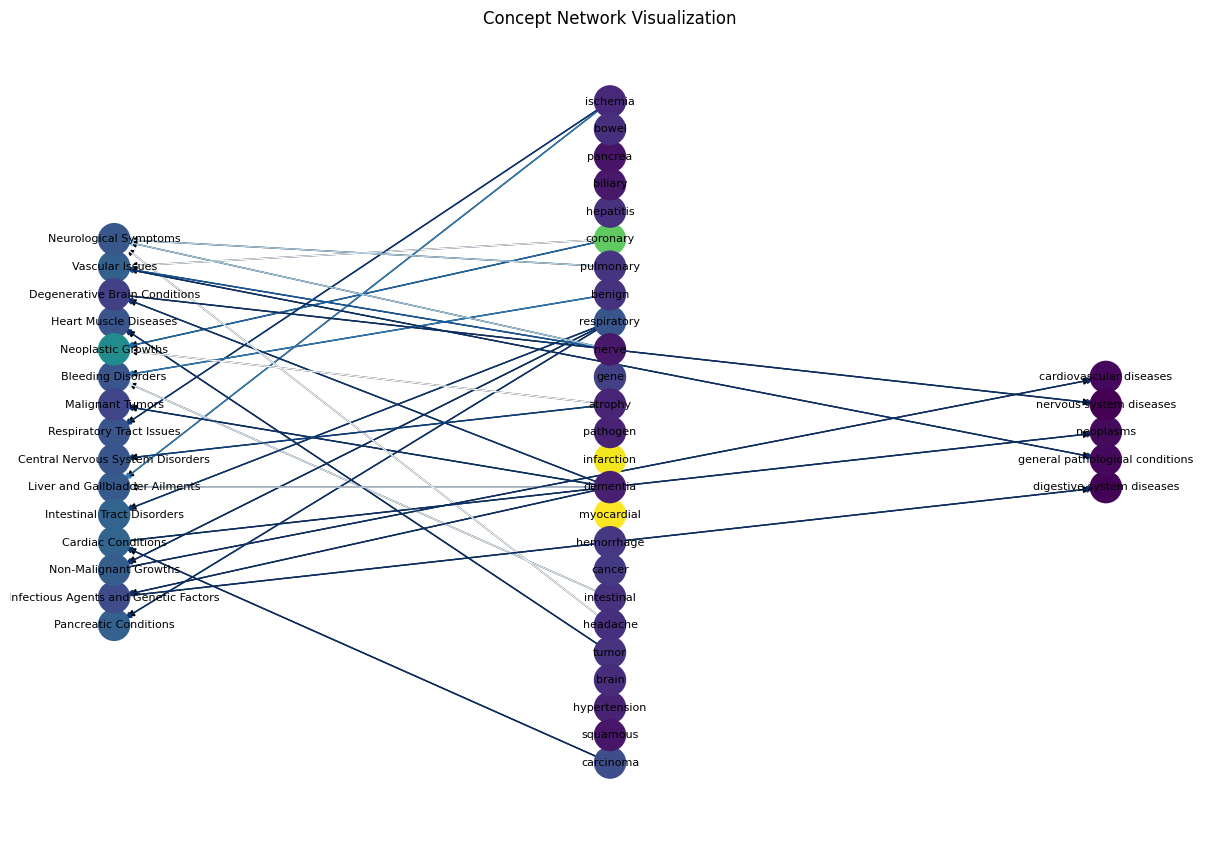

In [28]:
# Interpretable prediction for a single test sample
if test_texts and test_labels:
    keyword_scores, abstract_scores, label_probs, predicted_label_idx = interpretable_prediction(
        model, test_texts[0], test_labels[0], test_keyword_scores, test_abstract_scores, concept_names, device=device
    )
    visualize_network(model, concept_names, keyword_scores, abstract_scores, label_probs, predicted_label_idx)